In [1]:
import sys
sys.path.insert(0, '../.')
import numpy as np
import math
from data.data_utils.reader_utils import read_calib
import tensorflow as tf
from data.detection_dataset_loader import *
from data.data_utils.data_reader import *
from data.data_utils.reader_utils import *
from model import *
from data.postprocessing.nms import *

/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env3/lib/python3.5/site-

In [2]:
import matplotlib.pyplot as plt

In [14]:
def read_label2(calib_reader, label_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(700, 800, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
#     print(len(lines))
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = calib_reader.read_calib()

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])

    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print(len(locations))
    # print(z_range)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#         if angles[i] < 0:
#             angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions
    else:
        return output, indxes


In [4]:
def nms2(label, scores, max_output_size=100, iou_threshold=0.1, sess=None):
    boxes = []

    for j in range(0, len(label)):

        w = label[j][3]
        h = label[j][4] 
        x = label[j][0]
        y = label[j][1]
        a = label[j][6]
        

        polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
        xs = polygon[0::2]
        ys = polygon[1::2]
            
        boxes.append([xs[0], ys[0], xs[2], ys[2]])

    boxes = np.array(boxes)
    with tf.Graph().as_default():
        selected_indices = tf.image.non_max_suppression(
                    boxes, scores, max_output_size=max_output_size, iou_threshold=iou_threshold)
        if sess is not None:
            selected_indices = sess.run(selected_indices)
        else:
            with tf.Session() as sess:
                selected_indices = sess.run(selected_indices)

    return selected_indices



In [15]:

def cart2hom(pts_3d):
    ''' Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    '''
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom

def project_velo_to_ref(pts_3d_velo, Tr_velo_to_cam):
    pts_3d_velo = cart2hom(pts_3d_velo) # nx4
    return np.dot(pts_3d_velo, np.transpose(Tr_velo_to_cam))

    
def project_ref_to_rect(pts_3d_ref, R0_rect):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(R0_rect, np.transpose(pts_3d_ref)))

def ProjectTo2Dbbox(center, h, w, l, r_y, P2):
    # input: 3Dbbox in (rectified) camera coords

    Rmat = np.asarray([[math.cos(r_y), 0, math.sin(r_y)],
                       [0, 1, 0],
                       [-math.sin(r_y), 0, math.cos(r_y)]],
                       dtype='float32')

    p0 = center + np.dot(Rmat, np.asarray([l/2.0, 0, w/2.0], dtype='float32').flatten())
    p1 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, w/2.0], dtype='float32').flatten())
    p2 = center + np.dot(Rmat, np.asarray([-l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p3 = center + np.dot(Rmat, np.asarray([l/2.0, 0, -w/2.0], dtype='float32').flatten())
    p4 = center + np.dot(Rmat, np.asarray([l/2.0, -h, w/2.0], dtype='float32').flatten())
    p5 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, w/2.0], dtype='float32').flatten())
    p6 = center + np.dot(Rmat, np.asarray([-l/2.0, -h, -w/2.0], dtype='float32').flatten())
    p7 = center + np.dot(Rmat, np.asarray([l/2.0, -h, -w/2.0], dtype='float32').flatten())

    points = np.array([p0, p1, p2, p3, p4, p5, p6, p7])

    points_hom = np.ones((points.shape[0], 4)) # (shape: (8, 4))
    points_hom[:, 0:3] = points

    # project the points onto the image plane (homogeneous coords):
    img_points_hom = np.dot(P2, points_hom.T).T # (shape: (8, 3)) (points_hom.T has shape (4, 8))
    # normalize:
    img_points = np.zeros((img_points_hom.shape[0], 2)) # (shape: (8, 2))
    img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
    img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

    u_min = np.min(img_points[:, 0])
    v_min = np.min(img_points[:, 1])
    u_max = np.max(img_points[:, 0])
    v_max = np.max(img_points[:, 1])

    left = int(u_min)
    top = int(v_min)
    right = int(u_max)
    bottom = int(v_max)

    projected_2Dbbox = [left, top, right, bottom]

    return projected_2Dbbox


def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(700, 800), output_size=(175, 200), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x+0.5, y+0.5, 1., anchors[0], anchors[1], anchors[2]])

            mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
            maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.85, 1.1, 1.1])
        
            out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
            
            out[:2] = out[:2] + anchor[:2]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
            out[3:6] = np.exp(out[3:6])
            
            out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)


def get_points(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(700, 800, 35), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = np.arctan2(converted_points_[6], converted_points_[7])
            result[15] = sigmoid(converted_points_[-1])

            
            calib_reader = CalibReader(calib_path)
            calib_data = calib_reader.read_calib()

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result


def prepare_dataset_feed_dict(model, dataset, train_fusion_rgb):
        data = dataset.get_next(batch_size=1)
        camera_tensor, lidar_tensor, label_tensor= data
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False,
                model.weight_cls: 1,
                model.weight_dim: 1,
                model.weight_loc: 1,
                model.weight_theta: 1}
        return d



In [13]:

def write_predictions(labels_output, calib_path, new_file_path, th=0.5, truth_value=None, is_label=False, base_path = '../../../Data'):
    converted_points = convert_prediction_into_real_values(labels_output, truth_value=truth_value, th=th, is_label=is_label)
#     print(len(converted_points))
    points = get_points(converted_points, calib_path, th=th)
#     print(len(points))
#     print('---')
    res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

def write_all_predictions(model, dir_name, training, augment=False, get_best=False, fusion=False, base_path = '../../../Data'):
    with model.graph.as_default():
            
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        with tf.Session(config=config) as sess:
            if get_best:
                model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp_best2/'))
            else:
                model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))

            dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training, augment=augment)
        
            cls_losses = []
            reg_losses = []
            total_losses = []
            i = 0
            
            apply_nms=False

            if training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(base_path + file_name, 'r') as f:
                            list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]
            list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            try:    
                while True:
                    feed_dict = prepare_dataset_feed_dict(model, dataset, fusion)
                    final_output= sess.run(model.final_output, feed_dict=feed_dict)
#                     print(i, np.where(sigmoid(final_output[0][:, :, :, -1])>=0.2))
                    if i < len(list_files):
                        current_file = list_files[i]

                        for th, th_str in zip([0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ['05', '10', '20', '30', '40', '50']):
                            new_file_path = '../prediction_files/' + dir_name + '/bev/th' + th_str + '_2/data/' + current_file + '.txt'
                            write_predictions(final_output[0], list_calib_paths[i], new_file_path, th=th)
                            
                    else:
                        break

                    i += 1
                    if i % 100 == 0:
                        print('i = ', i)
            except tf.errors.OutOfRangeError:
                pass
            except StopIteration:
                pass
            finally:
                print('Done')

In [7]:
def write_predictions_nms(th, new_file_path, old_file_path, calib_reader, base_path = '../../../Data'):
    
    res = []
    with open(old_file_path) as label_file:
            res = label_file.readlines()
    res = ''.join(res)
    points2 = res.split('\n')
    points = []
    for i in range(len(points2)):
        temp = []
        temp = points2[i].split(' ')
        points.append(temp)
#     print('here')
    labels, indxes = read_label2(calib_reader, res, 0, 0, get_actual_dims=True, from_file=False)

    points = np.array(points)
#     print('here')
    if len(labels) > 0:
        points = points[indxes]
        selected_idx = nms2(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
    else:
        selected_idx = []

    if len(selected_idx) > 0:
        points = points[selected_idx]
        res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
    else:
        res=""
    
    text_file = open(new_file_path, "wb+")
    text_file.write(res.encode())
    text_file.close()

def get_augmentation_parameters():
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    return rot, tr, sc, image_translate_x, image_translate_y, ang
    
def write_all_predictions_nms(old_dir, training, base_path = '../../../Data'):
    i = 0       
    try:    
        while True:
            
            if training:
                file_name = '/trainsplit.txt'
            else:
                            file_name = '/valsplit.txt'
            with open(base_path + file_name, 'r') as f:
                            list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

            list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
            list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
            list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
            list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            rot, tr, sc, image_translate_x, image_translate_y, ang = get_augmentation_parameters()
            
            if i < len(list_files):
                current_file = list_files[i]
                data_reader_obj = DataReader(list_camera_paths[i],
                             list_calib_paths[i], 
                             list_label_paths[i], 
                             list_lidar_paths[i], 
                            rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=True)
            
                for th, th_str in zip([0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ['05', '10', '20', '30', '40', '50']):
                    old_file_path = '../prediction_files/' + old_dir + '/bev/th' + th_str + '_2/data/' + current_file + '.txt'
                    new_file_path = '../prediction_files/' + old_dir + '/nms/th' + th_str + '_2/data/' + current_file + '.txt'
                    write_predictions_nms(th, new_file_path, old_file_path, data_reader_obj.calib_reader)
      
            else:
                break
            i += 1
            if i % 100 == 0:
                print('i = ', i)
    except tf.errors.OutOfRangeError as e:
        print("i at break1 = ", i)
    except StopIteration as e:
        print("i at break2 = ", i)
    except Exception as e:
        print("i at break3 = ", i, e)

In [8]:
dir_name = 'pixor_train_3'

In [9]:
# !rm -r "../prediction_files/pixor_train_2"

In [10]:
# !mkdir "../prediction_files"
!mkdir "../prediction_files/""$dir_name"
!mkdir "../prediction_files/""$dir_name""/bev/"
!mkdir "../prediction_files/""$dir_name""/bev/th05_2"
!mkdir "../prediction_files/""$dir_name""/bev/th05_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2"
!mkdir "../prediction_files/""$dir_name""/bev/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2"
!mkdir "../prediction_files/""$dir_name""/bev/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2"
!mkdir "../prediction_files/""$dir_name""/bev/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2"
!mkdir "../prediction_files/""$dir_name""/bev/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2"
!mkdir "../prediction_files/""$dir_name""/bev/th50_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/"
!mkdir "../prediction_files/""$dir_name""/nms/th05_2"
!mkdir "../prediction_files/""$dir_name""/nms/th05_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th10_2"
!mkdir "../prediction_files/""$dir_name""/nms/th10_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th20_2"
!mkdir "../prediction_files/""$dir_name""/nms/th20_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th30_2"
!mkdir "../prediction_files/""$dir_name""/nms/th30_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th40_2"
!mkdir "../prediction_files/""$dir_name""/nms/th40_2/data"
!mkdir "../prediction_files/""$dir_name""/nms/th50_2"
!mkdir "../prediction_files/""$dir_name""/nms/th50_2/data"

In [16]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)

In [17]:
write_all_predictions(model, dir_name, training=True, augment=False, get_best=False, fusion=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-287196
i =  100
i =  200
i =  300
i =  400
i =  500
i =  600
i =  700
Done


KeyboardInterrupt: 

In [18]:
write_all_predictions_nms(dir_name, training=True)

i =  100
i =  200
i =  300
i =  400
i =  500
i =  600
i =  700
i at break3 =  791 [Errno 2] No such file or directory: '../prediction_files/pixor_train_3/bev/th05_2/data/001600.txt'


In [37]:
write_all_predictions(model, dir_name, training=False, augment=False, get_best=True, fusion=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp_best2/model.ckpt-55230
i =  100
i =  200
i =  300
i =  400
i =  500
Done


KeyboardInterrupt: 

In [38]:
write_all_predictions_nms(dir_name, training=False)

i =  100
i =  200
i =  300
i =  400
i =  500
i at break3 =  528 [Errno 2] No such file or directory: '../prediction_files/pixor_test_2_best/bev/th05_2/data/001074.txt'


In [19]:
def get_stats(model, training, augment=False, get_best=False, fusion=False, base_path = '../../../Data'):
    with model.graph.as_default():
            
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        with tf.Session(config=config) as sess:
            if get_best:
                model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp_best2/'))
            else:
                model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))

            dataset = DetectionDatasetLoader(base_path='../../../Data', training_per=0.5, batch_size=1, random_seed=0, training=training, augment=augment)
        
            cls_losses = []
            reg_losses = []
            total_losses = []
            i = 0
            
            apply_nms=False

            if training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(base_path + file_name, 'r') as f:
                            list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]
            list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            cls_losses = []
            dim_losses = []
            loc_losses = []
            theta_losses = []
            ious = []
            dim_ious = []
            loc_ious = []
            theta_diffs = []
            precisions = []
            recalls = []
            try:  
                c = 0
                while c < 200:
                    feed_dict = prepare_dataset_feed_dict(model, dataset, fusion)
                    
                    final_output, cls_loss, loc_loss, dim_loss, theta_loss,\
                        reg_loss, iou, iou_dim, iou_loc, precision, recall, theta_accuracy = sess.run([model.final_output,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                             model.regression_loss,\
                                                             model.iou, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall,\
                                                              model.theta_accuracy ],\
                                                             feed_dict=feed_dict) 
                    cls_losses.append(cls_loss)
                    dim_losses.append(dim_loss)
                    loc_losses.append(loc_loss)
                    theta_losses.append(theta_loss)
                    ious.append(iou)
                    dim_ious.append(iou_dim)
                    loc_ious.append(iou_loc)
                    theta_diffs.append(theta_accuracy)
                    precisions.append(precision)
                    recalls.append(recall)
                    c += 1
            except: 
                pass
                    
            return cls_losses, dim_losses, loc_losses, theta_losses, ious, dim_ious, loc_ious, theta_diffs, precisions, recalls
        

In [21]:
cls_losses, dim_losses, loc_losses, theta_losses,\
            ious, dim_ious, loc_ious, theta_diffs,\
            precisions, recalls = get_stats(model, training=True, get_best=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-287196


In [33]:
ious = np.array(ious)
np.where((ious < 0.5) & (ious > 0))

(array([ 42,  50, 141, 162, 178]),)

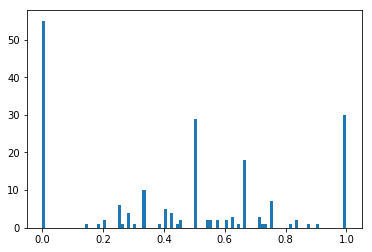

In [22]:
plt.hist(recalls, bins=100)
plt.show()

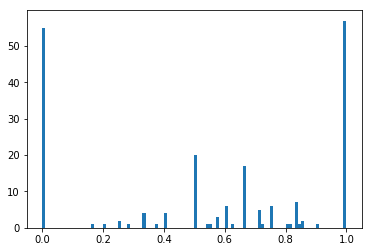

In [23]:
plt.hist(precisions, bins=100)
plt.show()

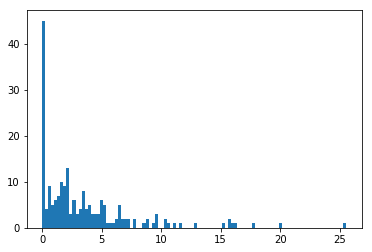

In [24]:
plt.hist(cls_losses, bins=100)
plt.show()

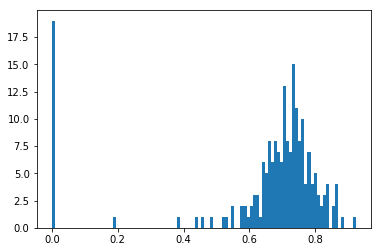

In [25]:
plt.hist(ious, bins=100)
plt.show()

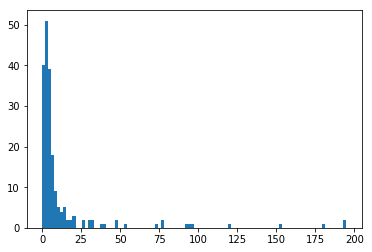

In [26]:
plt.hist(theta_diffs, bins=100)
plt.show()

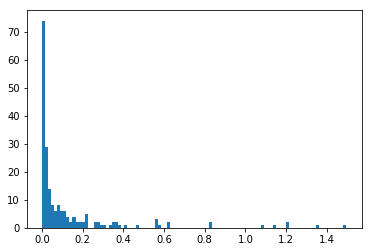

In [27]:
plt.hist(theta_losses, bins=100)
plt.show()

In [20]:
cls_losses_test, dim_losses_test, loc_losses_test, theta_losses_test,\
            ious_test, dim_ious_test, loc_ious_test, theta_diffs_test,\
            precisions_test, recalls_test = get_stats(model, training=False, get_best=True)

INFO:tensorflow:Restoring parameters from ../training_files/tmp_best2/model.ckpt-55230


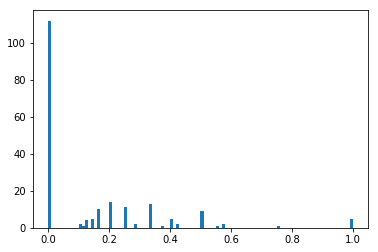

In [21]:
plt.hist(recalls_test, bins=100)
plt.show()

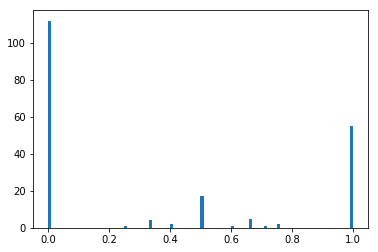

In [22]:
plt.hist(precisions_test, bins=100)
plt.show()

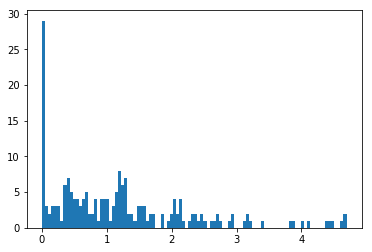

In [23]:
plt.hist(cls_losses_test, bins=100)
plt.show()

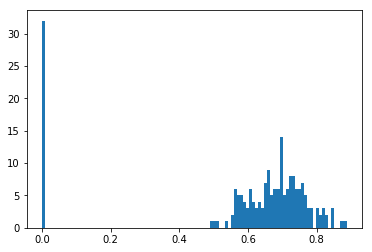

In [24]:
plt.hist(ious_test, bins=100)
plt.show()

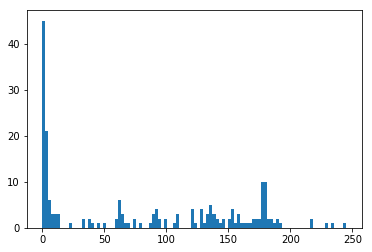

In [25]:
plt.hist(theta_diffs_test, bins=100)
plt.show()

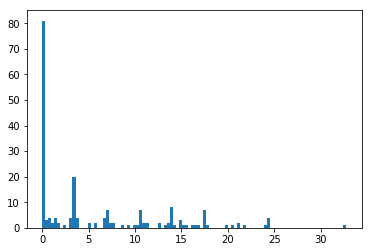

In [26]:
plt.hist(theta_losses_test, bins=100)
plt.show()

In [27]:
cls_losses_test2, dim_losses_test2, loc_losses_test2, theta_losses_test2,\
            ious_test2, dim_ious_test2, loc_ious_test2, theta_diffs_test2,\
            precisions_test2, recalls_test2 = get_stats(model, training=False, get_best=False)

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-147280


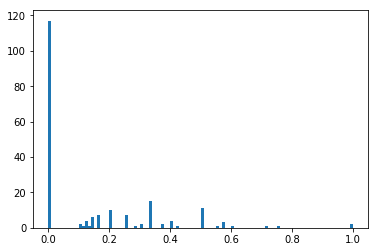

In [28]:
plt.hist(recalls_test2, bins=100)
plt.show()

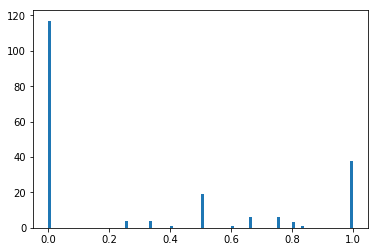

In [29]:
plt.hist(precisions_test2, bins=100)
plt.show()

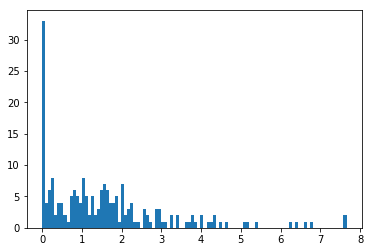

In [30]:
plt.hist(cls_losses_test2, bins=100)
plt.show()

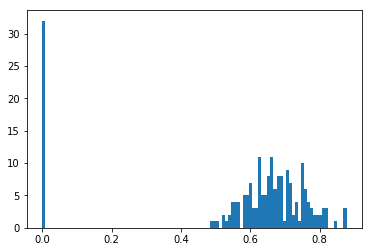

In [31]:
plt.hist(ious_test2, bins=100)
plt.show()

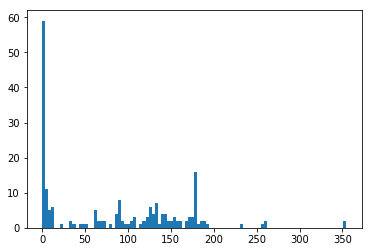

In [32]:
plt.hist(theta_diffs_test2, bins=100)
plt.show()

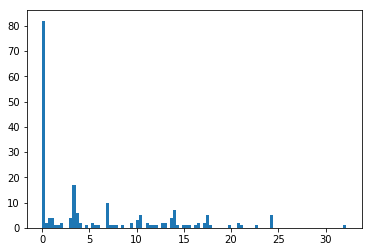

In [33]:
plt.hist(theta_losses_test2, bins=100)
plt.show()